# **Pedestrian Behavior Analysis in Traffic Using Machine Learning**

###**Problem Statement** <br>
Understanding pedestrian movement patterns in traffic is crucial for urban planning, traffic safety, and autonomous vehicle navigation. This project explores regression, classification, and clustering techniques to analyze pedestrian behavior using real-world tracking data. <br> <br>
<h4>Objectives:
<ol>
<li>Regression: Predict pedestrian movement (next position, speed, acceleration).
<li>Classification: Identify different pedestrian types based on movement patterns.
<li>Clustering: Detect high-density pedestrian zones and group similar movement behaviors.





DATA PREPROCESSING

In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


In [ ]:


# Load the dataset
tracks_file_path = "/content/tracks.csv"  # Update path if needed
tracks_df = pd.read_csv(tracks_file_path)

# Display dataset information
print("Dataset Info:")
tracks_df.info()

# Display first few rows
print("\nFirst 5 Rows:")
print(tracks_df.head())

# Convert object-type columns (stored as lists in strings) to actual lists
list_columns = ["other_oid", "other_class", "other_x", "other_y"]
for col in list_columns:
    tracks_df[col] = tracks_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert "None" strings to actual NaN values in body and head orientation columns
orientation_cols = ["body_roll", "body_pitch", "body_yaw", "head_roll", "head_pitch", "head_yaw"]
tracks_df[orientation_cols] = tracks_df[orientation_cols].replace("None", pd.NA)

# Fill missing values with 0 in orientation columns
tracks_df[orientation_cols] = tracks_df[orientation_cols].fillna(0)

# Convert list columns to string format for duplicate detection
for col in list_columns:
    tracks_df[col] = tracks_df[col].astype(str)

# Check for duplicate rows
duplicate_count = tracks_df.duplicated().sum()
tracks_df = tracks_df.drop_duplicates()
print(f"\nDuplicates Removed: {duplicate_count}")

# Normalize x and y coordinates
scaler = MinMaxScaler()
tracks_df[["x", "y"]] = scaler.fit_transform(tracks_df[["x", "y"]])

# Display summary statistics after normalization
print("\nNormalized Coordinate Statistics:")
print(tracks_df[["x", "y"]].describe())




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4759 entries, 0 to 4758
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   oid          4759 non-null   int64  
 1   timestamp    4759 non-null   float64
 2   x            4759 non-null   float64
 3   y            4759 non-null   float64
 4   body_roll    2061 non-null   float64
 5   body_pitch   2061 non-null   float64
 6   body_yaw     2061 non-null   float64
 7   head_roll    2061 non-null   float64
 8   head_pitch   2061 non-null   float64
 9   head_yaw     2061 non-null   float64
 10  other_oid    4759 non-null   object 
 11  other_class  4759 non-null   object 
 12  other_x      4759 non-null   object 
 13  other_y      4759 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 520.6+ KB

First 5 Rows:
     oid  timestamp              x             y  body_roll  body_pitch  \
0  50187     1842.4  495854.640310  5.405751e+06     

EDA (EXPLORATORY DATA ANALYSIS)


Summary Statistics:
                oid    timestamp            x            y    body_roll  \
count   4759.000000  4759.000000  4759.000000  4759.000000  4759.000000   
mean   36158.947258  1169.678924     0.497003     0.559548     0.131661   
std    15992.323879   800.496866     0.212121     0.423811     0.909294   
min     7682.000000   217.500000     0.000000     0.000000    -7.000000   
25%    19348.000000   317.500000     0.376748     0.022718     0.000000   
50%    42054.000000   925.400000     0.481517     0.824380     0.000000   
75%    49654.000000  1837.850000     0.664372     0.924887     0.000000   
max    50943.000000  2650.800000     1.000000     1.000000    10.800000   

        body_pitch     body_yaw    head_roll   head_pitch     head_yaw  
count  4759.000000  4759.000000  4759.000000  4759.000000  4759.000000  
mean     -0.308270    82.526661    -0.109919    -0.470370    80.712141  
std       1.530334   108.273371     2.315212     3.762937   105.606551  
min     -18

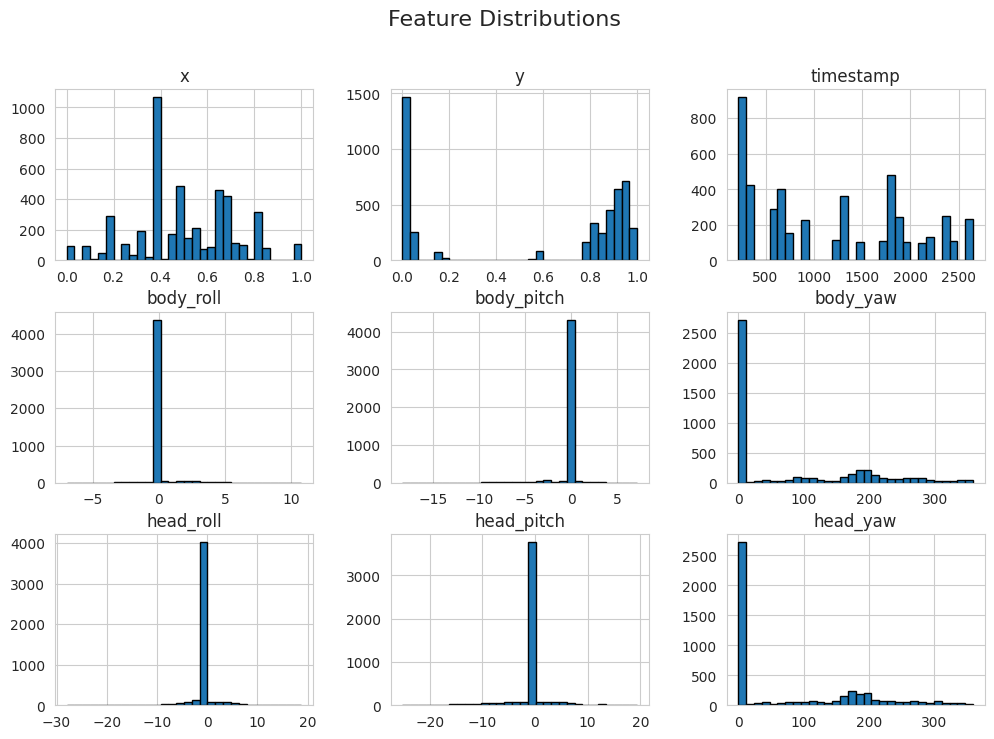

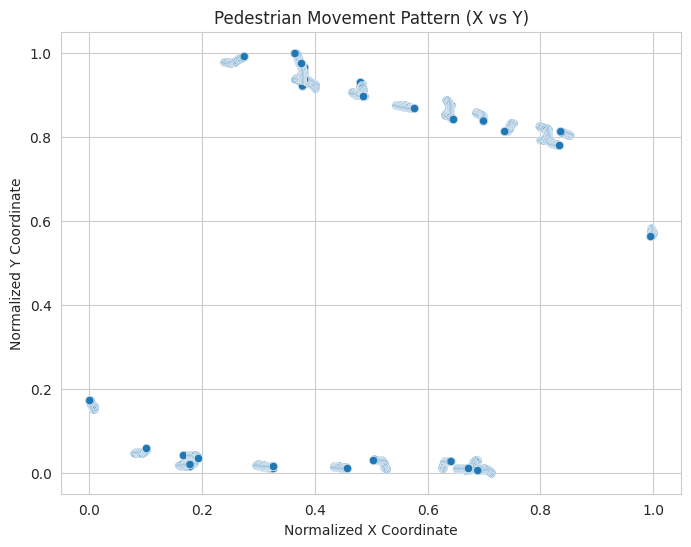

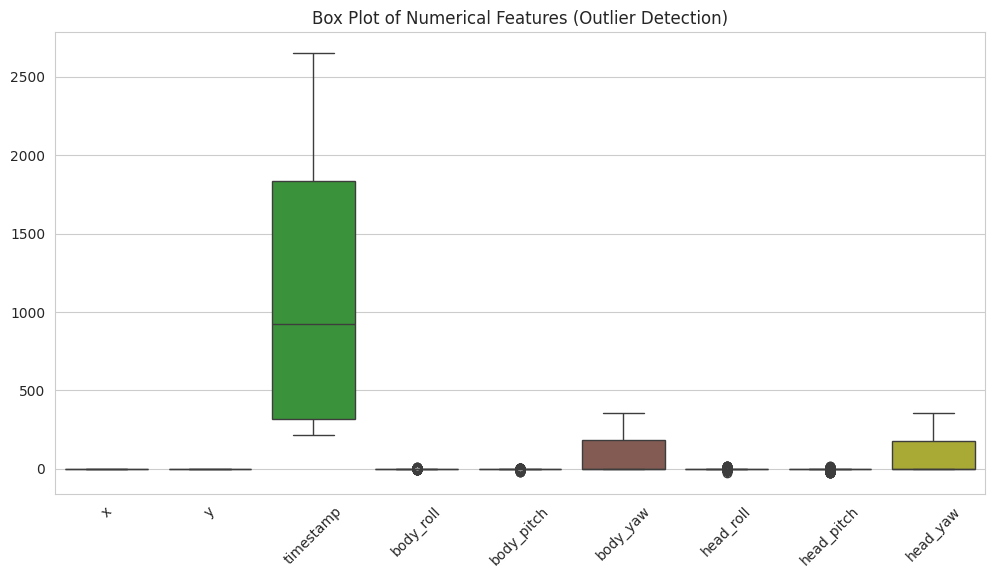


Preprocessing and EDA Complete. Cleaned dataset saved as 'cleaned_tracks.csv'.


In [ ]:
# Exploratory Data Analysis (EDA)
sns.set_style("whitegrid")

# Generate summary statistics
summary_stats = tracks_df.describe()
print("\nSummary Statistics:")
print(summary_stats)

# Plot histograms for numerical columns
numerical_cols = ["x", "y", "timestamp"] + orientation_cols
tracks_df[numerical_cols].hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Scatter plot of x vs y (pedestrian movement pattern)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tracks_df, x="x", y="y", alpha=0.5)
plt.title("Pedestrian Movement Pattern (X vs Y)")
plt.xlabel("Normalized X Coordinate")
plt.ylabel("Normalized Y Coordinate")
plt.show()

# Box plots to check for outliers in numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=tracks_df[numerical_cols])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features (Outlier Detection)")
plt.show()

# Save the cleaned dataset
tracks_df.to_csv("/content/cleaned_tracks.csv", index=False)
print("\nPreprocessing and EDA Complete. Cleaned dataset saved as 'cleaned_tracks.csv'.")

OUTLIER REMOVAL

In [ ]:
# Outlier Removal using Z-score
def remove_outliers(df, cols, threshold=3):
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df = df[(np.abs(df[col] - mean) / std) < threshold]
    return df

tracks_df = remove_outliers(tracks_df, ["x", "y"] + orientation_cols)
print("\nOutliers Removed")



Outliers Removed


FEATURE ENGINEERING: COMPUTE SPEED AND ACCELERATION

The original dataset includes:

<ul><li>frame or timestamp

<li>x, y positions of pedestrians

<li>track_id (to identify individuals)</ul>


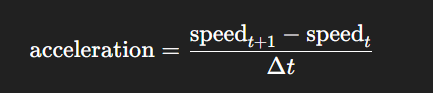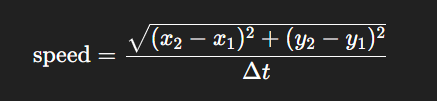




In [ ]:
# Feature Engineering: Compute Speed and Acceleration
tracks_df = tracks_df.sort_values(by=["oid", "timestamp"])  # Ensure data is ordered
tracks_df["prev_x"] = tracks_df.groupby("oid")["x"].shift(1)
tracks_df["prev_y"] = tracks_df.groupby("oid")["y"].shift(1)
tracks_df["prev_time"] = tracks_df.groupby("oid")["timestamp"].shift(1)

# Compute speed (distance/time) while handling division by zero
tracks_df["time_diff"] = tracks_df["timestamp"] - tracks_df["prev_time"]
tracks_df["time_diff"] = tracks_df["time_diff"].replace(0, np.nan)  # Avoid division by zero
tracks_df["speed"] = np.sqrt((tracks_df["x"] - tracks_df["prev_x"])**2 + (tracks_df["y"] - tracks_df["prev_y"])**2) / tracks_df["time_diff"]
tracks_df["speed"] = tracks_df["speed"].fillna(0)

# Compute acceleration (change in speed over time)
tracks_df["prev_speed"] = tracks_df.groupby("oid")["speed"].shift(1)
tracks_df["acceleration"] = (tracks_df["speed"] - tracks_df["prev_speed"]) / tracks_df["time_diff"]
tracks_df["acceleration"] = tracks_df["acceleration"].fillna(0)

# Drop helper columns
tracks_df = tracks_df.drop(columns=["prev_x", "prev_y", "prev_time", "prev_speed", "time_diff"])

###REGRESSION <br>
In this project, regression will be used to predict **pedestrian speed** based on various features like position (x, y), orientation angles, and time-based movement patterns. <br> <br>
Target Variable for Regression: <br>
Speed → The velocity of a pedestrian (calculated from position and time).<br> <br>
<br>
#####PARAMETERS USED

1. Linear & Polynomial Regression<br>
✔ Position (x, y) – Normalized pedestrian coordinates.<br>
✔ Timestamp (time) – Time of movement.<br>
✔ Body Orientation (body_roll, body_pitch, body_yaw) – Rotation angles of the pedestrian.<br>
✔ Head Orientation (head_roll, head_pitch, head_yaw) – Direction the pedestrian is facing.<br>

 Velocity is predicted as a function of these spatial and orientation features.

2. Random Forest & XGBoost Regression<br>
✔ All features from Linear Regression, plus:<br>
✔ Acceleration (speed change over time) – Measures change in speed at different timestamps.<br>
✔ Other Pedestrians (other_x, other_y) – Distance to nearby pedestrians.<br>
✔ Interaction Features – Possible calculated distances to objects.<br>

 These models learn complex, non-linear relationships between movement features and speed.<br><br>
Use Cases:
<ol>
<li>Predict Future Speed – Estimate how fast a pedestrian will move in the next time step.
<li>Traffic Flow Analysis – Understand movement patterns for better urban planning.
<li>Autonomous Systems – Help self-driving cars anticipate pedestrian movement.
</ol>

FEATURE SELECTION

In [ ]:
# Feature Selection for Regression
# Remove non-numeric columns before applying mutual_info_regression
X = tracks_df.select_dtypes(include=[np.number]).drop(columns=["speed", "acceleration", "oid"], errors='ignore')
y = tracks_df["speed"]  # Target variable for regression


SPLITTING THE DATA

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nData Splitting Complete: Training and Testing sets created.")



Data Splitting Complete: Training and Testing sets created.


# LINEAR REGRESSION


Linear Regression Model Performance:
MAE: 0.0008005730999012035
MSE: 1.1467346759858736e-06
RMSE: 0.0010708569820409603
R² Score: 0.01484263148341336


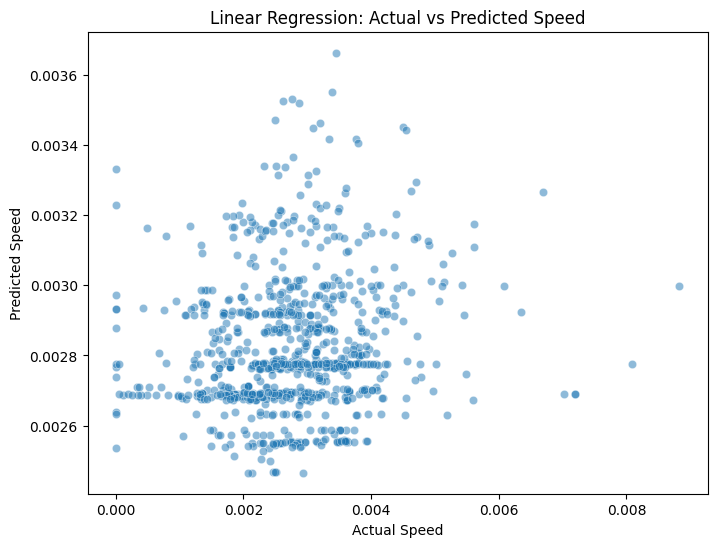

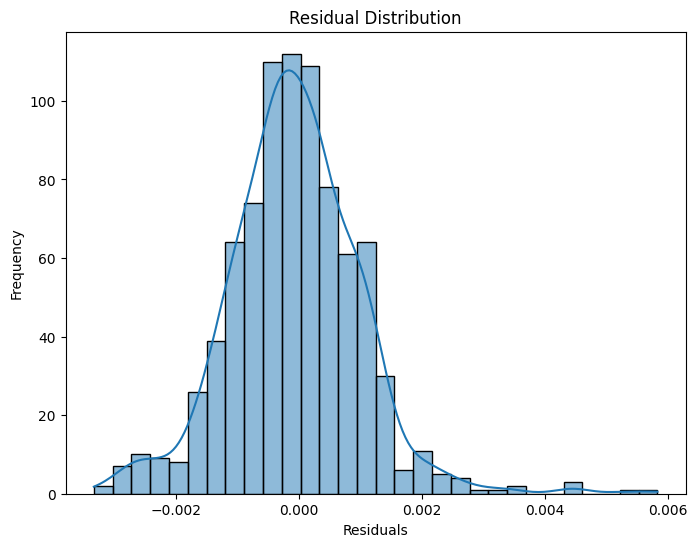

In [ ]:
# Train Linear Regression Model
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predict on test set
y_pred = model1.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Visualize Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.title("Linear Regression: Actual vs Predicted Speed")
plt.show()

# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


###LINEAR REGRESSION ANALYSIS <br>

---



MAE (Mean Absolute Error) = 0.0008
On average, predictions are off by 0.0008 speed units (low error). <br>


MSE (Mean Squared Error) = 1.146 × 10⁻⁶<br>
Squared errors are very small (good sign). <br>


RMSE (Root Mean Squared Error) = 0.00107<br>
Similar to MAE but penalizes large errors more; still very low.<br>



R² Score = 0.0148 (1.48%)<br>
Very low, meaning the model explains only 1.48% of speed variation (not ideal). <br><br>


---


Low Errors (MAE, MSE, RMSE) → Model predictions are numerically close to actual values.<br>
Poor R² Score (1.48%) → Model fails to capture important factors affecting pedestrian speed.<br><br>


---


Conclusion: Linear Regression is too simple for this dataset.





#POLYNOMIAL REGRESSION








Polynomial Regression Model Performance:
MAE: 0.0007788243543075421
MSE: 1.1141438269899054e-06
RMSE: 0.0010555301165717185
R² Score: 0.04284136188457288


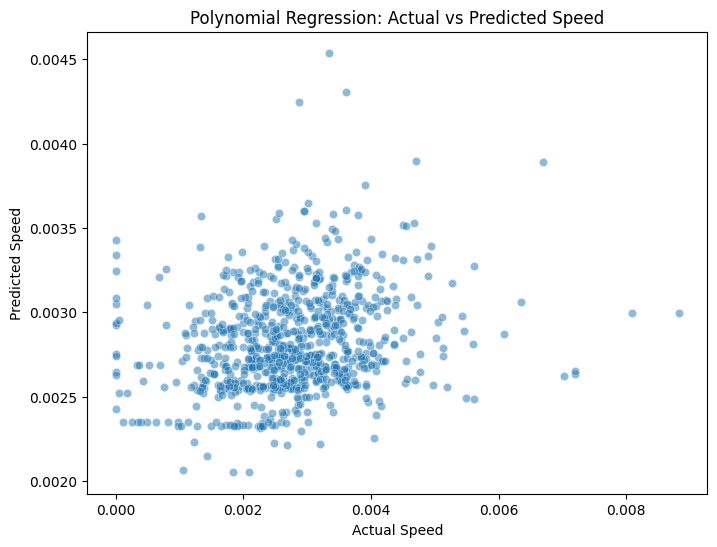

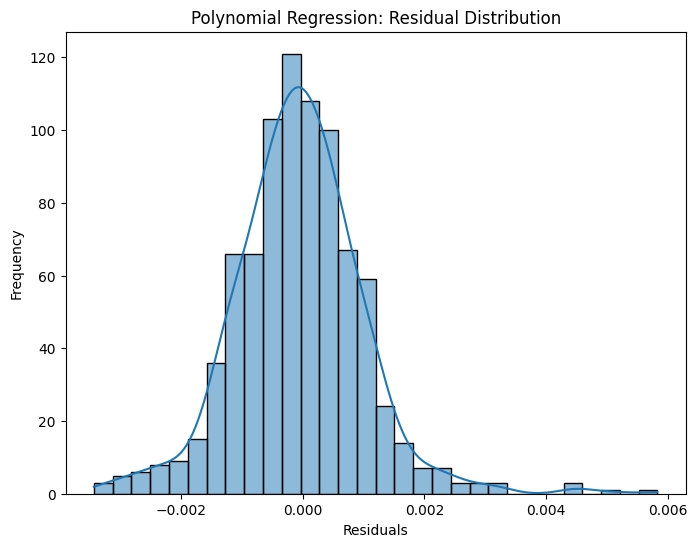

In [ ]:
# Train Polynomial Regression Model
poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_train, y_train)

# Predict on test set
y_pred_poly = poly_reg.predict(X_test)

# Evaluate Model Performance
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("\nPolynomial Regression Model Performance:")
print(f"MAE: {mae_poly}")
print(f"MSE: {mse_poly}")
print(f"RMSE: {rmse_poly}")
print(f"R² Score: {r2_poly}")

# Visualize Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.5)
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.title("Polynomial Regression: Actual vs Predicted Speed")
plt.show()

# Plot Residuals
residuals_poly = y_test - y_pred_poly
plt.figure(figsize=(8, 6))
sns.histplot(residuals_poly, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Polynomial Regression: Residual Distribution")
plt.show()

###POLYNOMIAL REGRESSION ANALYSIS <br>

---



MAE (Mean Absolute Error) = 0.00078
On average, predictions are off by 0.00078 speed units (low error). <br>


MSE (Mean Squared Error) = 1.114 × 10⁻⁶<br>
Squared errors are very small, indicating minor prediction deviations. <br>


RMSE (Root Mean Squared Error) = 0.00106<br>
Similar to MAE but penalizes larger errors; still very low.<br>



R² Score = 0.0428 (4.28%)<br>
Slightly better than Linear Regression but still low (poor model fit) <br><br>


---


Errors (MAE, MSE, RMSE) are low, meaning predictions are numerically close to actual values.<br>
R² Score (4.28%) is higher than Linear Regression (1.48%), but the model still does not explain much variance in speed.<br><br>


---


Conclusion: Polynomial Regression slightly improves prediction accuracy but is still too simple for this dataset.

#WHY RIDGE AND LASSO REGRESSION WON'T WORK

Ridge Regression adds penalty terms to reduce overfitting and handle multicollinearity in linear models.<br>
Lasso Regression performs feature selection by shrinking unimportant coefficients to zero.
<br><br>
<ol>
<li>We have already performed Linear Regression and found out it has performed poorly. The R² score for Linear Regression was only 1.48%, meaning a linear model does not capture speed variations well. Ridge/Lasso are still linear models, so they won’t fix this issue.<br><br>


<li>Secondly, Polynomial Regression Gave Only a Small Boost. Even with non-linearity (degree=2), R² improved only slightly to 4.28%. This suggests that the relationship between the features and speed is highly non-linear, making regularization ineffective. <br><br>

<li>Ridge & Lasso Do Not Handle Non-Linearity Well. These methods only adjust feature weights—they do not learn complex patterns like decision trees or neural networks.
</ol>

#RANDOM FOREST REGRESSOR

Random Forest Regression is an ensemble learning method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting. It is well-suited for non-linear relationships and provides better predictive power than traditional regression models. By leveraging multiple trees, it captures complex patterns in pedestrian speed, making it a significant improvement over Linear and Polynomial Regression.


Random Forest Regression Model Performance:
MAE: 0.000419230545466784
MSE: 4.853989057529683e-07
RMSE: 0.0006967057526337559
R² Score: 0.5829948124126354


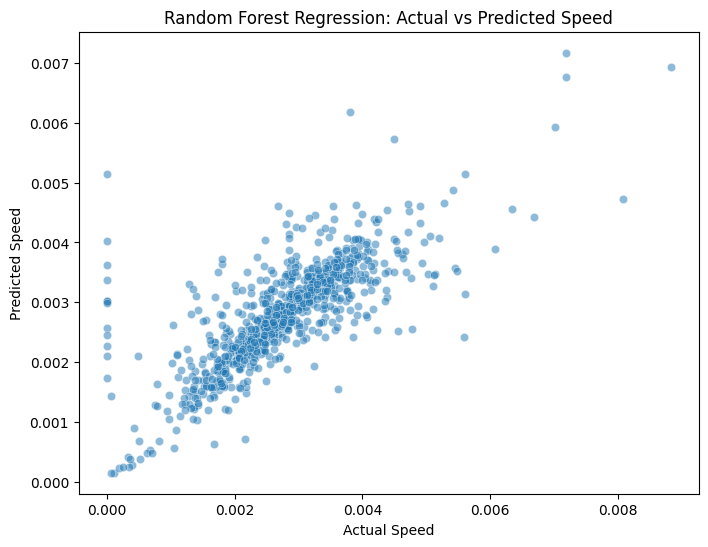

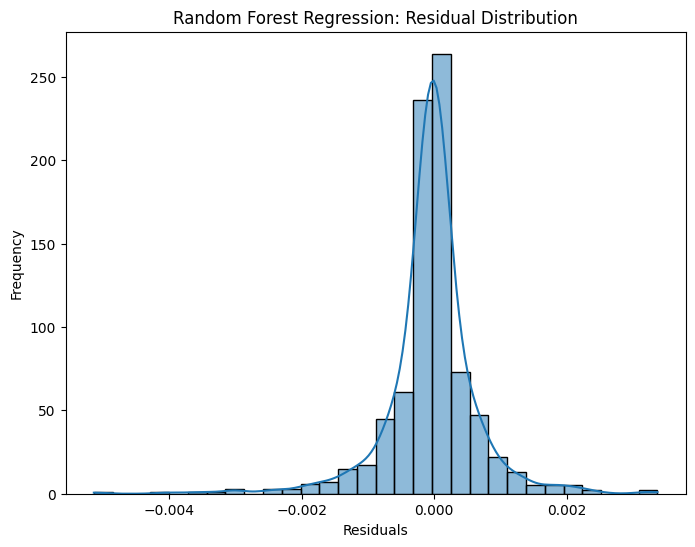

In [ ]:
# Train Random Forest Regression Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_reg.predict(X_test)

# Evaluate Model Performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Model Performance:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R² Score: {r2_rf}")

# Visualize Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.title("Random Forest Regression: Actual vs Predicted Speed")
plt.show()

# Plot Residuals
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Random Forest Regression: Residual Distribution")
plt.show()

###RANDOM FOREST REGRESSION ANALYSIS <br>

---



MAE (Mean Absolute Error) = 0.00042
Predictions are off by 0.00042 speed units on average (lower than Linear & Polynomial). <br>


MSE (Mean Squared Error) = 4.85 × 10⁻⁷<br>
Very small squared errors, indicating accurate predictions. <br>


RMSE (Root Mean Squared Error) = 0.00070<br>
Lower than Linear & Polynomial Regression (better performance).<br>



R² Score = 0.5830 (58.3%)<br>
The model explains 58.3% of speed variation (major improvement over previous models).<br><br>


---


Low Errors (MAE, MSE, RMSE) → Predictions are much closer to actual values.<br>
Random Forest captures non-linearity better, making it far superior to previous models.<br><br>


---


Conclusion: Significant Improvement over Linear Regression (R² = 1.48%) and Polynomial Regression (R² = 4.28%).

#XGBOOST REGRESSION


XGBoost Regression Model Performance:
MAE: 0.0005467057406483863
MSE: 6.413208742854261e-07
RMSE: 0.0008008251209130656
R² Score: 0.4490425744363118


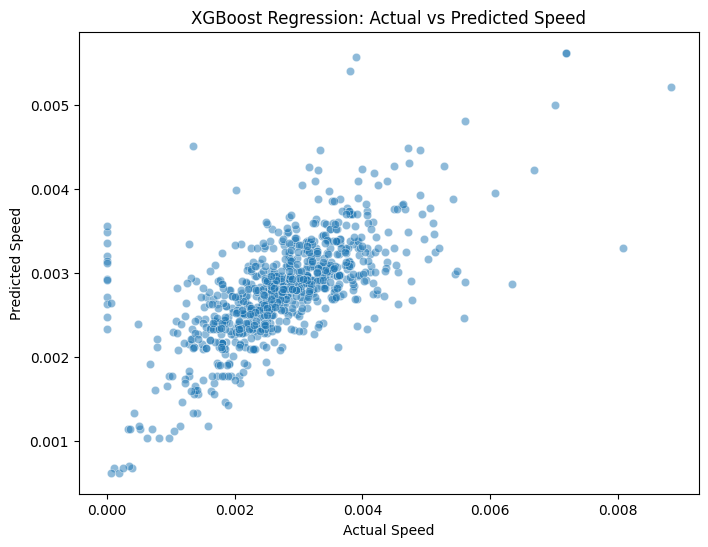

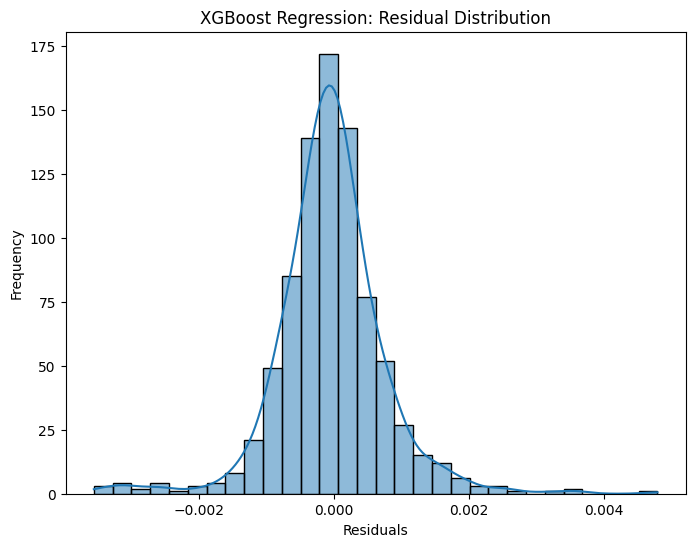

In [ ]:
# Train XGBoost Regression Model
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluate Model Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Model Performance:")
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R² Score: {r2_xgb}")

# Visualize Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5)
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.title("XGBoost Regression: Actual vs Predicted Speed")
plt.show()

# Plot Residuals
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("XGBoost Regression: Residual Distribution")
plt.show()

###XGBOOST REGRESSION ANALYSIS <br>

---



MAE (Mean Absolute Error) = 0.00055
Predictions are off by 0.00055 speed units on average (higher than Random Forest). <br>


MSE (Mean Squared Error) = 6.41 × 10⁻⁷<br>
Slightly higher squared errors compared to Random Forest. <br>


RMSE (Root Mean Squared Error) = 0.00080<br>
Higher than Random Forest, meaning slightly worse predictive accuracy<br>



R² Score = 0.4490 (44.9%)<br>
Lower than Random Forest (58.3%), meaning XGBoost explains less variance in speed.<br><br>


---


Higher MAE, MSE, and RMSE indicate more errors compared to Random Forest.<br>
Random Forest captures non-linearity better, making it far superior to previous models.<br><br>


---


Conclusion: XGBoost performed worse than Random Forest (R² = 44.9% vs. 58.3%). Random Forest remains the best model so far.

#SVR REGRESSION


Support Vector Regression (SVR) Model Performance:
MAE: 0.002345238683075951
MSE: 6.4380097437911935e-06
RMSE: 0.0025373233423809415
R² Score: -4.530880743816984


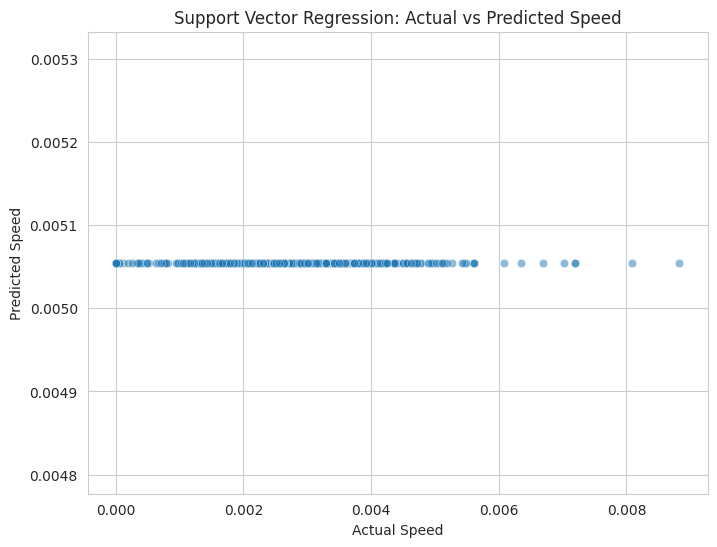

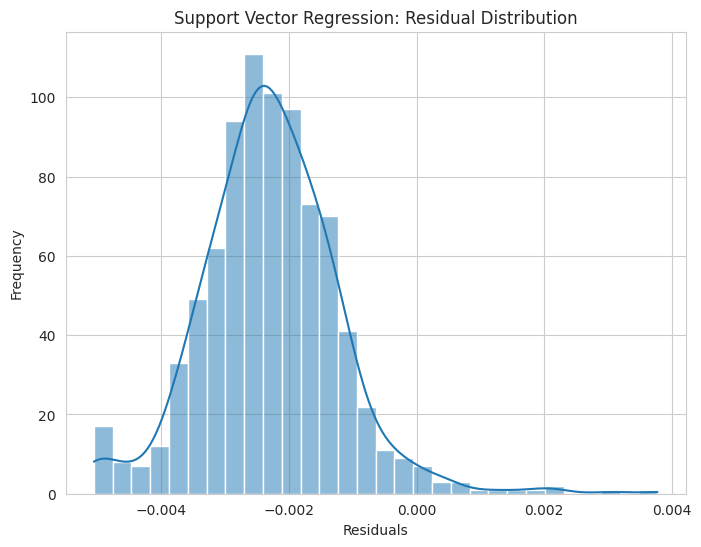

In [ ]:
# Train Support Vector Regression (SVR) Model
svr_reg = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.01))
svr_reg.fit(X_train, y_train)

# Predict on test set
y_pred_svr = svr_reg.predict(X_test)

# Evaluate Model Performance
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSupport Vector Regression (SVR) Model Performance:")
print(f"MAE: {mae_svr}")
print(f"MSE: {mse_svr}")
print(f"RMSE: {rmse_svr}")
print(f"R² Score: {r2_svr}")

# Visualize Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.5)
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.title("Support Vector Regression: Actual vs Predicted Speed")
plt.show()

# Plot Residuals
residuals_svr = y_test - y_pred_svr
plt.figure(figsize=(8, 6))
sns.histplot(residuals_svr, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Support Vector Regression: Residual Distribution")
plt.show()

#TRYING TO IMPROVE RANDOM FOREST




In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = rf_grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the optimized model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print("Optimized Random Forest Regression Model Performance:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Regression Model Performance:
MAE: 0.00041634178754556113
MSE: 4.782936411121017e-07
RMSE: 0.0006915877681915013
R² Score: 0.5890989304469072


#TRYING TO IMPROVE XGBOOST

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1
)

# Train the model
grid_search.fit(X_train, y_train)

# Best Parameters & Performance
print("Best Parameters:", grid_search.best_params_)

# Evaluate the optimized model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Performance Metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print("\nOptimized XGBoost Regression Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}

Optimized XGBoost Regression Model Performance:
MAE: 0.00048665511662954056
MSE: 5.457726150624883e-07
RMSE: 0.0007387642486358475
R² Score: 0.5311278846598684


#STACKING

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define base models
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1)),
    ('xgboost', XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7, subsample=0.8)),
    ('ridge', Ridge(alpha=1.0))
]

# Define meta-model (Final estimator)
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_regressor.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_stacking)
mse = mean_squared_error(y_test, y_pred_stacking)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_stacking)

# Print results
print("Stacking Regression Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


Stacking Regression Model Performance:
MAE: 0.0004251907703558501
MSE: 4.821625801145648e-07
RMSE: 0.0006943792768470016
R² Score: 0.5857751330189267


#NEURAL NETWORKS

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Neural Network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=100, batch_size=32,
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_pred_nn = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_nn)
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

print("Neural Network Regression Model Performance:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8413 - mae: 0.6623 - val_loss: 0.0217 - val_mae: 0.1002
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1479 - mae: 0.2882 - val_loss: 0.0303 - val_mae: 0.1105
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0877 - mae: 0.2209 - val_loss: 0.0303 - val_mae: 0.1277
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0677 - mae: 0.1912 - val_loss: 0.0207 - val_mae: 0.1102
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - mae: 0.1622 - val_loss: 0.0164 - val_mae: 0.0936
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - mae: 0.1471 - val_loss: 0.0099 - val_mae: 0.0732
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - mae: 0.1181 - val_loss: 0.0094 - val_mae: 0.0784
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - mae: 0.1075 - val_loss: 0.0058 - val_mae: 0.0576
Epoch 9/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the MLP model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predictions
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Neural Network (MLP) Regression Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network (MLP) Regression Model Performance:
MAE: 0.0009157820480390161
MSE: 2.869292354627894e-06
RMSE: 0.0016938985668061397
R² Score: -1.4650030776821112


###CLASSIFICATION

<br>
Classification is a supervised learning task where a model learns to assign labels to data based on features. In this project, we aim to classify pedestrian risk levels based on their movement behavior.
<br>

<u>Labels & Risk Level Definition</u><br>
We categorize pedestrian movement into two risk levels:

Risk Level (Label)	vs Description<br>
Low Risk (0)	- Pedestrian is moving steadily, with normal speed and acceleration.<br>
High Risk (1) - 	Pedestrian is showing erratic behavior, sudden stops, rapid acceleration, or unsafe proximity to others.<br><br>
<u>Features (Parameters Used for Classification)</u><br>
We use the following features to classify risk:

- Speed (speed) – High speed combined with sudden stops may indicate risk.<br>
- Acceleration (acceleration) – Rapid changes in acceleration suggest erratic movement.<br>
- Orientation Angles (body_roll, body_pitch, body_yaw) – Sharp changes in angles indicate sudden turns or instability.<br>
- Proximity to Others (other_x, other_y) – Closeness to other pedestrians or objects may indicate risk.<br>

<u>Use Cases of Risk Classification</u><br>
- Autonomous Vehicles: Predict pedestrian movement risk for safer driving.
- Smart Traffic Management: Detect high-risk pedestrian behavior at crossings.
- Surveillance & Safety Monitoring: Identify erratic pedestrian behavior in crowded areas.

In [ ]:
# Define risk level based on speed and acceleration
# Risk Level (1 = High Risk, 0 = Low Risk)
def classify_risk(speed, acceleration):
    if speed > 0.005 or acceleration > 0.02:  # Adjusted thresholds
        return 1  # High Risk
    return 0  # Low Risk

tracks_df['risk_level'] = tracks_df.apply(lambda row: classify_risk(row['speed'], row['acceleration']), axis=1)

# Train-Test Split for Classification
X_class = tracks_df[["speed", "acceleration", "body_roll", "body_pitch", "body_yaw"]]
y_class = tracks_df["risk_level"]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

#LOGISTIC REGRESSION


Logistic Regression Classification Model Performance:
Accuracy: 0.698090692124105

Confusion Matrix:
[[574 232]
 [ 21  11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       806
           1       0.05      0.34      0.08        32

    accuracy                           0.70       838
   macro avg       0.50      0.53      0.45       838
weighted avg       0.93      0.70      0.79       838



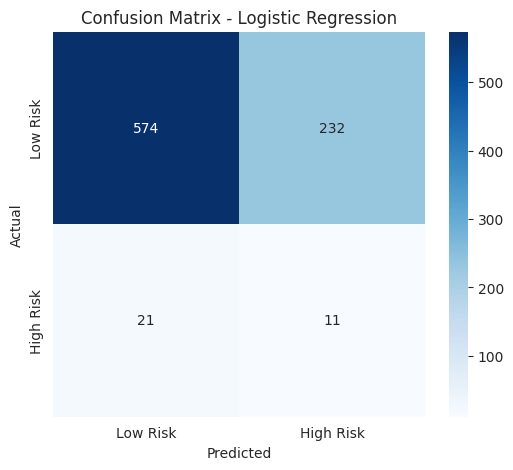

In [ ]:
# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train_class, y_train_class)


# Predict on test set
y_pred_class = log_reg.predict(X_test_class)

# Evaluate Classification Model
accuracy = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print("\nLogistic Regression Classification Model Performance:")
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Risk", "High Risk"], yticklabels=["Low Risk", "High Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


###LOGISTIC REGRESSION ANALYSIS <br>





#RANDOM FOREST

In [ ]:

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train_class, y_train_class)

# Predict on the test data
y_pred_rf = rf_clf.predict(X_test_class)

# Evaluate the model
print("Random Forest Classification Model Performance:")
print("Accuracy:", accuracy_score(y_test_class, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_class, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_rf))


Random Forest Classification Model Performance:
Accuracy: 1.0

Confusion Matrix:
 [[806   0]
 [  0  32]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00        32

    accuracy                           1.00       838
   macro avg       1.00      1.00      1.00       838
weighted avg       1.00      1.00      1.00       838



##CHECKING OVERFITTING

In [ ]:


# Define the classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate scores
cv_scores = cross_val_score(rf_clf, X_class, y_class, cv=skf, scoring='accuracy')

# Print results
print("Cross-validation scores:", cv_scores)
print("Mean Accuracy: {:.4f}".format(np.mean(cv_scores)))
print("Standard Deviation: {:.4f}".format(np.std(cv_scores)))


Cross-validation scores: [1.         1.         1.         0.99880668 1.        ]
Mean Accuracy: 0.9998
Standard Deviation: 0.0005


Your Random Forest classifier is not overfitting — it's performing consistently well on unseen data during cross-validation.<br><br>

This means:

- features are meaningful,

- risk level thresholds are effective,

- the model is well-tuned (at least for this dataset).

#NAIVE BAYES

In [ ]:


# Initialize Naive Bayes classifier
nb_model = GaussianNB()

# Fit the model
nb_model.fit(X_train_class, y_train_class)

# Predict on test data
y_pred_nb = nb_model.predict(X_test_class)

# Evaluation
print("Naive Bayes Classification Model Performance:")
print("Accuracy:", accuracy_score(y_test_class, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_class, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_nb))

# Cross-validation
nb_cv_scores = cross_val_score(nb_model, X_class, y_class, cv=5)
print("\nCross-validation scores:", nb_cv_scores)
print("Mean Accuracy:", nb_cv_scores.mean())
print("Standard Deviation:", nb_cv_scores.std())


Naive Bayes Classification Model Performance:
Accuracy: 0.9486873508353222

Confusion Matrix:
 [[783  23]
 [ 20  12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       806
           1       0.34      0.38      0.36        32

    accuracy                           0.95       838
   macro avg       0.66      0.67      0.67       838
weighted avg       0.95      0.95      0.95       838


Cross-validation scores: [0.96062053 0.96300716 0.93317422 0.94988067 0.95584726]
Mean Accuracy: 0.9525059665871123
Standard Deviation: 0.010657333442370473


#SVM

In [ ]:

# Initialize SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Fit the model
svm_model.fit(X_train_class, y_train_class)

# Predict on test data
y_pred_svm = svm_model.predict(X_test_class)

# Evaluation
print("SVM Classification Model Performance:")
print("Accuracy:", accuracy_score(y_test_class, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_class, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_svm))

# Cross-validation
svm_cv_scores = cross_val_score(svm_model, X_class, y_class, cv=5)
print("\nCross-validation scores:", svm_cv_scores)
print("Mean Accuracy:", svm_cv_scores.mean())
print("Standard Deviation:", svm_cv_scores.std())


SVM Classification Model Performance:
Accuracy: 0.9618138424821002

Confusion Matrix:
 [[806   0]
 [ 32   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       806
           1       0.00      0.00      0.00        32

    accuracy                           0.96       838
   macro avg       0.48      0.50      0.49       838
weighted avg       0.93      0.96      0.94       838



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validation scores: [0.95942721 0.95942721 0.95823389 0.95823389 0.95823389]
Mean Accuracy: 0.9587112171837708
Standard Deviation: 0.0005846037572275281


#CLUSTERING

Clustering is an unsupervised machine learning technique that groups similar data points together based on their features. In the context of pedestrian behavior analysis, clustering helps identify patterns in how pedestrians move, such as their speed, acceleration, and movement tendencies in different traffic conditions.<br><br>

By applying clustering algorithms like K-Means, DBSCAN, and Hierarchical Clustering, we can categorize pedestrians into different behavioral groups. These clusters can help in:

- Understanding Pedestrian Risk Levels: Identifying groups of pedestrians who are more likely to engage in risky behavior, such as sudden stops or erratic movements.

- Traffic Management: Assisting urban planners in optimizing pedestrian pathways and crosswalks to reduce congestion and accidents.

- Improved Model Performance: Clustering insights can be used as additional features for classification or regression tasks, leading to more accurate risk assessments.
<br>
By segmenting pedestrians into meaningful groups, we can derive actionable insights that contribute to safer and more efficient urban mobility systems.

#K MEANS CLUSTERING

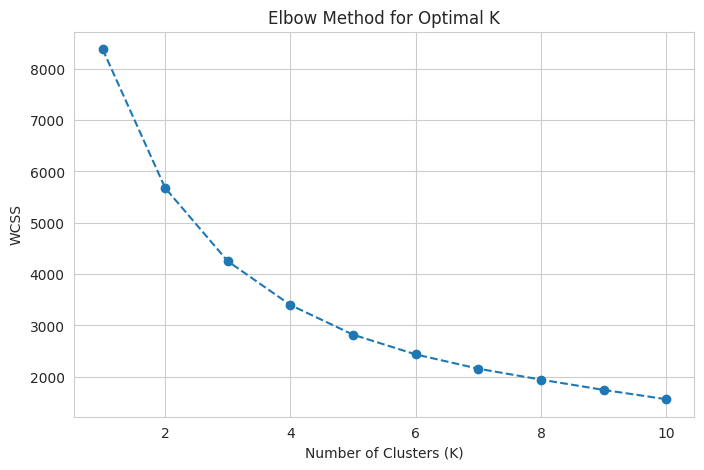

In [ ]:


# Select relevant features for clustering
features = ['speed', 'acceleration']
X = tracks_df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find optimal K
wcss = []  # Within-Cluster Sum of Squares
k_values = range(1, 11)  # Testing K from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia measures WCSS

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


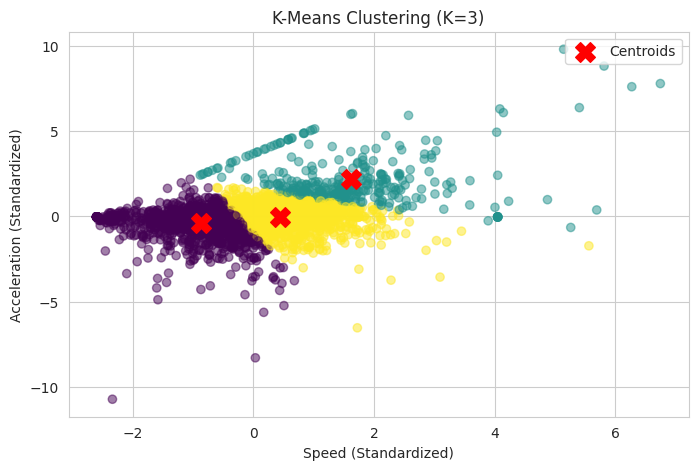

In [ ]:
# Apply K-Means with the chosen K
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)  # Assign clusters

# Add cluster labels to the original dataframe
tracks_df['Cluster'] = clusters

# Visualizing the clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centroids')  # Mark centroids
plt.xlabel('Speed (Standardized)')
plt.ylabel('Acceleration (Standardized)')
plt.title('K-Means Clustering (K=3)')
plt.legend()
plt.show()


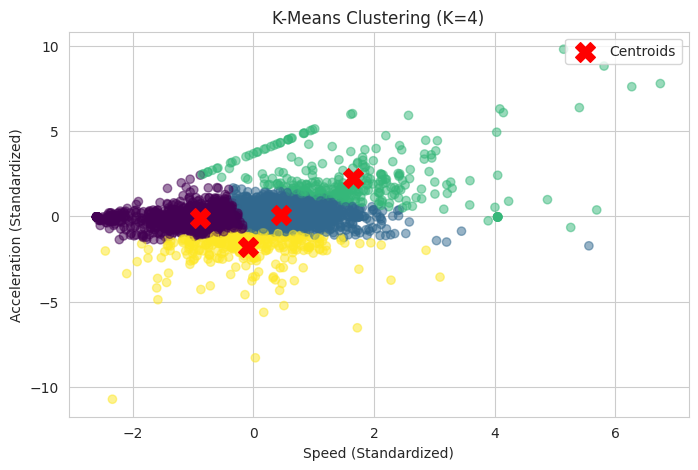

In [ ]:
# Apply K-Means with the chosen K
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)  # Assign clusters

# Add cluster labels to the original dataframe
tracks_df['Cluster'] = clusters

# Visualizing the clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centroids')  # Mark centroids
plt.xlabel('Speed (Standardized)')
plt.ylabel('Acceleration (Standardized)')
plt.title('K-Means Clustering (K=4)')
plt.legend()
plt.show()


#DBSCAN CLUSTERING

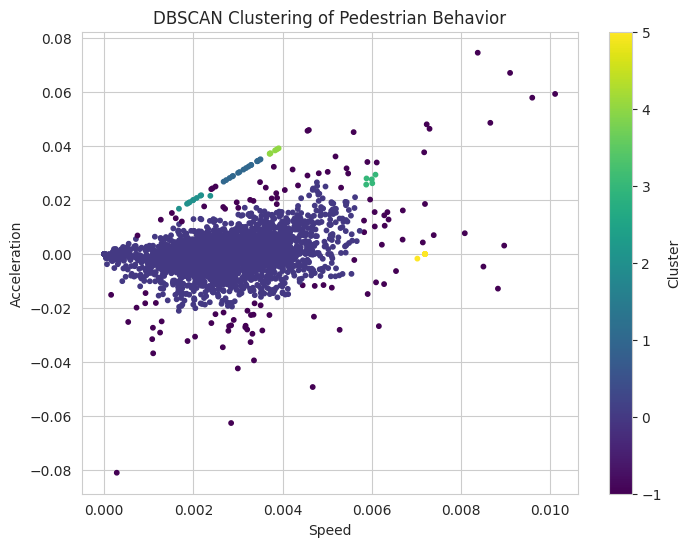

In [ ]:


# Select features for clustering (you can adjust based on your project focus)
features = tracks_df[['speed', 'acceleration']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize DBSCAN (tune eps and min_samples based on data distribution)
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(features_scaled)

# Assign cluster labels to DataFrame
tracks_df['dbscan_cluster'] = clusters


plt.figure(figsize=(8, 6))
plt.scatter(tracks_df['speed'], tracks_df['acceleration'], c=tracks_df['dbscan_cluster'], cmap='viridis', s=10)
plt.title("DBSCAN Clustering of Pedestrian Behavior")
plt.xlabel("Speed")
plt.ylabel("Acceleration")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()




___